In [1]:
import matplotlib.pyplot as plt
bigfontsize=10
labelfontsize=8
tickfontsize=8
plt.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

# Вероятностное машинное обучение

В предыдущих лекциях мы показали важность вероятностной интерпретации предсказаний алгоритмов машинного обучения и показали как исползовать распределeние вероятности предсказаний для принятия решений. Давайте рассмотрим несколько примеров оценки вероятности в машинном обучении.

## Задачи классиикации

Задача классификации сводится к соотношению входного вектора с определенным классом. Для учета вероятностной природы алгоритмов машинного обучения можно рассматривать не только наиболее вероятный класс, но и вероятность принадлежности к классу. Другими словами, мы хотим знать не только к какому классу относится входной вектор, но и с какой вероятностью.


### Логистическая регрессия 

Некоторые алгоритмы машинного обучения позволяют получить такую вероятность без дополнительных усилий. Рассмотрим логистистическую регресию. В простейем случае вероятность принадлдежности к классу описывается значением сигмоида:


$$p(y|\textbf{x}, \textbf{θ}) = Ber(y|\sigma(\textbf{w}^T\textbf{x} + b))$$

$$\sigma(\textbf{w}^T\textbf{x} + b)) = \frac{1}{1+e^{-\textbf{w}^T\textbf{x} - b}}$$

В ходе обучения логистической регрессии мы находим значения параметров $\textbf{w}$ и $b$ минимизирующие функцию потерь (например, MLE). Отметим, что если мы хотим строго следовать байесовскому подходу, то в ходе тренировки алгоритма мы получим апостериорное распределение параметров модели $p(\textbf{θ}|\mathcal{D})$, которое можно будет использовать для определения вероятности ассоциации новых векторов:

$$p(y|\mathcal{D}) = \int Ber(y|\sigma(\textbf{w}^T\textbf{x} + b)) P(\textbf{w},b|\mathcal{D})d\textbf{w}db$$

### Непараметрические модели

Однако зачастую полчить вероятность в явном виде как функцию параметров является навозможно. Это истино для непараметрических моделей, таких как модели основаные на решающих деревьях. Тем не менее, такие модели все же могут предоставить вероятность классификации в некоторых реализациях. Таким свойством обладают, например, модели из пакета ```sklearn```. Такие вероятности могут определяться частотами отнесения к определенным классам для ансамблированнх моделей или количеством представителей классов в листе единичного дерева.

### Калибровка вероятностей

Независимо от метода машинного обучения, предсказанная вероятность может отличаться от частотной вероятности на выборке. Пусть, например, модель классифицировала 100 из 100 входных векторов как класс 1 с вероятностью 90%, и все входящие вектора дествительно принадлежат этому классу. Такой результат немного противоречит ожиданиям, где 90 из 100 векторов действительно принадлежат классу 1, а 10 из 100 - нет.

Для обечпечения равенства ожидаемой и наблюдаемой вероятносей, возможно откалибровать выбраный алгоритм. 

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

In [3]:
from sklearn.calibration import CalibrationDisplay 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (rfc, "Random forest"),
]

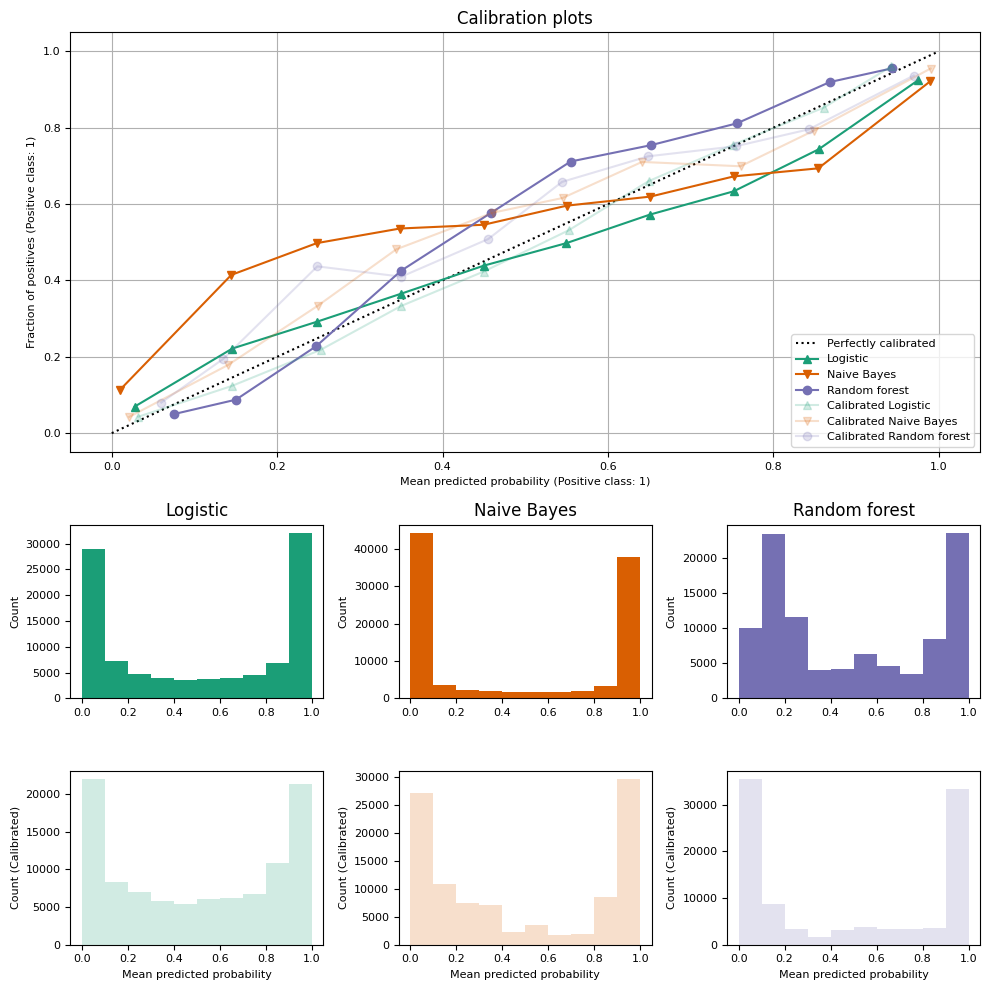

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 3)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :3])
calibration_displays = {}
markers = ["^", "v", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

for i, (clf, name) in enumerate(clf_list):
    calibrated_clf = CalibratedClassifierCV(clf, method='isotonic')
    calibrated_clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        calibrated_clf,
        X_test,
        y_test,
        n_bins=10,
        name="Calibrated "+name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
        alpha = 0.2
    )
    calibration_displays["Calibrated "+name] = display
    

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (2, 2)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, ylabel="Count")
grid_positions = [(3, 0), (3, 1), (3, 2)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays["Calibrated "+name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
        alpha = 0.2
    )    
    ax.set(xlabel="Mean predicted probability", ylabel="Count (Calibrated)")

plt.tight_layout()
plt.show()

## Задачи регрессии

Учет вероятностной природы машинного обучения в задачах регрессии сводится к анализу распределений значений предсказаний. Другими словами, вместо классической задачи сопоставлнеия вектора значений $\textbf{y}$ входнму вектору параметорв $\textbf{x}$ мы должны искать распределение $p(\textbf{y})$ соответсвующее входному вектору $\textbf{x}$.

### Параметрические модели

Использование параметрических моделей машинного обучения (таких как линейная регрессия) позволяет довольно просто найти распределение выходного вектора. В самом деле, параметрические модели позволяют однозначно определить предсказаный вектор по входному вектору $\textbf{x}$ и вектору параметров $\textbf{θ}$:

 $$\textbf{y} = f(\textbf{x}, \textbf{θ})$$
 
В классическом (не-вероятностом) машинном обучении мы находим значения параметров $ \textbf{θ}$ минимизирующие функцию потерь (например, MLE) и используем это значение для предсказаний. Однако если мы рассмотрим  $ \textbf{θ}$  как случайную величину (распределенную по апостериорному распределению $p(\textbf{θ}|\mathcal{D})$), то  вектора предсказаний так же будет случайной величиной. В соотвествтии с рассуждениями приведенными в лекции 3, мы можем получить распределение  $\textbf{y}$ в явном виде если преобразование $f(\textbf{x}, \textbf{θ})$ непрерывно по $ \textbf{θ}$ или мы можем восопльзоваться численными методами, например аппроксимацией Монте-Карло.

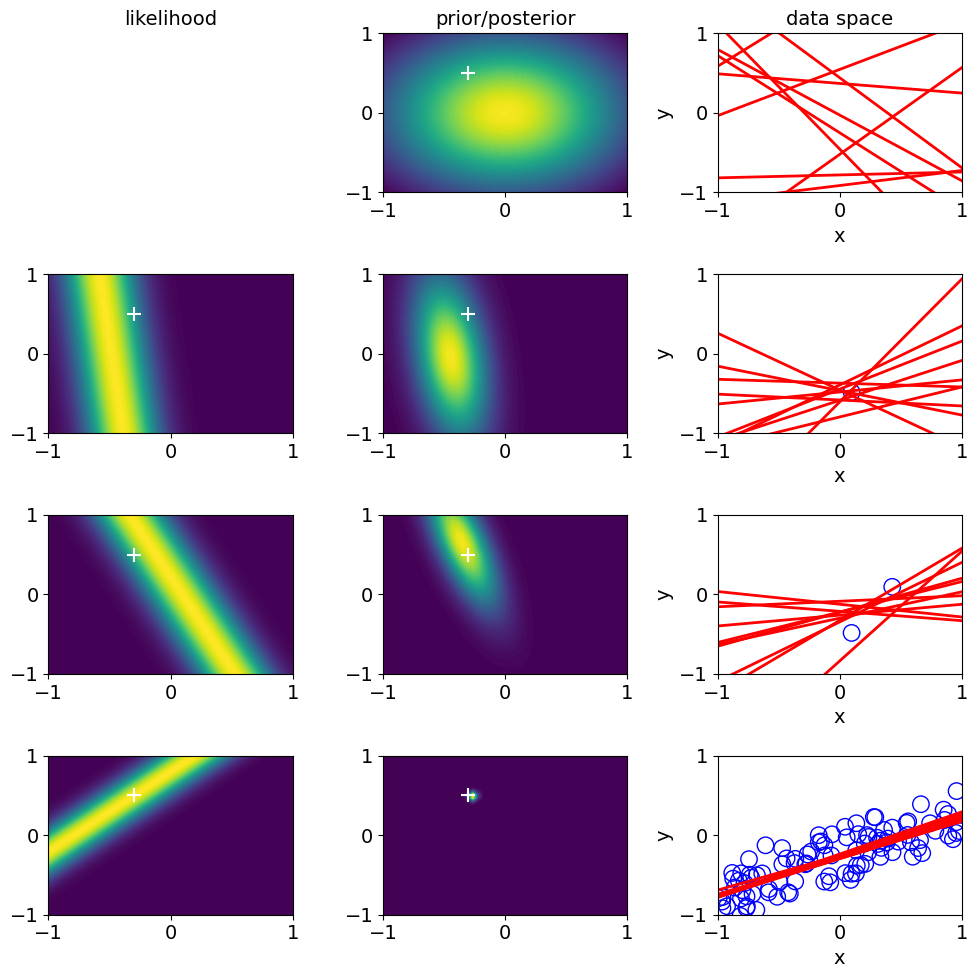

In [5]:
# Example from 
# https://github.com/probml/pyprobml/blob/auto_notebooks_md/notebooks.md#linreg_2d_bayes_demo.ipynb

# Bayesian inference for simple linear regression with known noise variance
# The goal is to reproduce fig 3.7 from Bishop's book.
# We fit the linear model f(x,w) = w0 + w1*x and plot the posterior over w.


import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import uniform, norm, multivariate_normal


# import seaborn
# import seaborn as sns
# seaborn.set()
# seaborn.set_style("whitegrid")

# Font sizes
SIZE_SMALL = 14
SIZE_MEDIUM = 18
SIZE_LARGE = 24

# https://stackoverflow.com/a/39566040
plt.rc("font", size=SIZE_SMALL)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_SMALL)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_SMALL)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_SMALL)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_SMALL)  # fontsize of the tick labels
plt.rc("legend", fontsize=SIZE_SMALL)  # legend fontsize
plt.rc("figure", titlesize=SIZE_LARGE)  # fontsize of the figure title


np.random.seed(0)

# Number of samples to draw from posterior distribution of parameters.
NSamples = 10

# Each of these corresponds to a row in the graphic and an amount of data the posterior will reflect.
# First one must be zero, for the prior.
DataIndices = [0, 1, 2, 100]

# True regression parameters that we wish to recover. Do not set these outside the range of [-1,1]
a0 = -0.3
a1 = 0.5

NPoints = 100  # Number of (x,y) training points
noiseSD = 0.2  # True noise standard deviation
priorPrecision = 2.0  # Fix the prior precision, alpha. We will use a zero-mean isotropic Gaussian.
likelihoodSD = noiseSD  # Assume the likelihood precision, beta, is known.
likelihoodPrecision = 1.0 / (likelihoodSD**2)

# Because of how axises are set up, x and y values should be in the same range as the coefficients.

x = 2 * uniform().rvs(NPoints) - 1
y = a0 + a1 * x + norm(0, noiseSD).rvs(NPoints)


def MeanCovPost(x, y):
    # Given data vectors x and y, this returns the posterior mean and covariance.
    X = np.array([[1, x1] for x1 in x])
    Precision = np.diag([priorPrecision] * 2) + likelihoodPrecision * X.T.dot(X)
    Cov = np.linalg.inv(Precision)
    Mean = likelihoodPrecision * Cov.dot(X.T.dot(y))
    return {"Mean": Mean, "Cov": Cov}


def GaussPdfMaker(mean, cov):
    # For a given (mean, cov) pair, this returns a vectorized pdf function.
    def out(w1, w2):
        return multivariate_normal.pdf([w1, w2], mean=mean, cov=cov)

    return np.vectorize(out)


def LikeFMaker(x0, y0):
    # For a given (x,y) pair, this returns a vectorized likelhood function.
    def out(w1, w2):
        err = y0 - (w1 + w2 * x0)
        return norm.pdf(err, loc=0, scale=likelihoodSD)

    return np.vectorize(out)


# Grid space for which values will be determined, which is shared between the coefficient space and data space.
grid = np.linspace(-1, 1, 50)
Xg = np.array([[1, g] for g in grid])
G1, G2 = np.meshgrid(grid, grid)

# If we have many samples of lines, we make them a bit transparent.
alph = 5.0 / NSamples if NSamples > 50 else 1.0

# A function to make some common adjustments to our subplots.
def adjustgraph(whitemark):
    if whitemark:
        plt.ylabel(r"")
        plt.xlabel(r"")
        plt.scatter(a0, a1, marker="+", color="white", s=100)
    else:
        plt.ylabel("y")
        plt.xlabel("x")
    plt.ylim([-1, 1])
    plt.xlim([-1, 1])
    plt.xticks([-1, 0, 1])
    plt.yticks([-1, 0, 1])
    return None


figcounter = 1
fig = plt.figure(figsize=(10, 10))

# Top left plot only has a title.
ax = fig.add_subplot(len(DataIndices), 3, figcounter)
ax.set_title("likelihood")
plt.axis("off")

# This builds the graph one row at a time.
for di in DataIndices:
    if di == 0:
        postM = [0, 0]
        postCov = np.diag([1.0 / priorPrecision] * 2)
    else:
        Post = MeanCovPost(x[:di], y[:di])
        postM = Post["Mean"]
        postCov = Post["Cov"]

        # Left graph
        figcounter += 1
        fig.add_subplot(len(DataIndices), 3, figcounter)
        likfunc = LikeFMaker(x[di - 1], y[di - 1])
        plt.contourf(G1, G2, likfunc(G1, G2), 100)
        adjustgraph(True)

    # Middle graph
    postfunc = GaussPdfMaker(postM, postCov)
    figcounter += 1
    ax = fig.add_subplot(len(DataIndices), 3, figcounter)
    plt.contourf(G1, G2, postfunc(G1, G2), 100)
    adjustgraph(True)
    # Set title if this is the top middle graph
    if figcounter == 2:
        ax.set_title("prior/posterior")

    # Right graph
    Samples = multivariate_normal(postM, postCov).rvs(NSamples)
    Lines = Xg.dot(Samples.T)
    figcounter += 1
    ax = fig.add_subplot(len(DataIndices), 3, figcounter)
    if di != 0:
        plt.scatter(x[:di], y[:di], s=140, facecolors="none", edgecolors="b")
    for j in range(Lines.shape[1]):
        plt.plot(grid, Lines[:, j], linewidth=2, color="r", alpha=alph)
    # Set title if this is the top right graph
    if figcounter == 3:
        ax.set_title("data space")
    adjustgraph(False)

fig.tight_layout()
plt.show()
     

Этот подход можно расширить на случай шумных данных. Для этого можно построить вероятностную модель включив в нее параметр описыващий шум. Например, пусть мы верим что для заданого вектора $\textbf{x}$ значения $y$ будут распределены нормально с $\mathcal{N}(\mu,\sigma^2)$, где $\mu$ описывает линейную регрессию (как в примере выше), а $ \sigma^2$ - шум данных. Обученая модель будет описывать распределение вероятностей для $y$ так:

$$p(y|x,\mathcal{D},\sigma^2) = \int \mathcal(y|\textbf{w}^T\textbf{x} + b,\sigma^2 )p(\textbf{w},b|\mathcal{D})d\textbf{w}db$$


Видно, что в данном случае дисперсия предсказаной величины будет зависить от распределения параметров  $\textbf{w},b$ и от шума данных $\sigma^2$.


### Непараметрические модели

Для непараметрических моделей ситуация оказывается сложнее. Для самой простой оценки распределения $y$ можно воспользоваться бутстрапом - как было продемонстрировано в Лекции 6. Идея этого подхода заключается в тренировке большого числа моделей на выборках из тренировочной выборки и анализа распределений $y$ полученых на разных моделях. Этот способ подходит для любой модели но он плохо масштабируется с ростом данных числа данных и сложностьи модели, может давать смещеную оценку, и не позволяет учитывать априорные знание о шуме данных.

Другим популярным подходом является выбор типа распределения для значения $y$ и тренировка непараметрических моделей для описания параметров этого распределения. Такой подход реализован в библиотеке [```ngboost```](https://stanfordmlgroup.github.io/projects/ngboost/): алгоритм этой библиотеки позволяет оценить дисперсию предсказания для заданой модели машинного обучения и вида распределения предсказаной величины.

[iter 0] loss=3.1984 val_loss=0.0000 scale=2.0000 norm=10.3102
[iter 100] loss=2.1644 val_loss=0.0000 scale=2.0000 norm=2.7076
[iter 200] loss=1.6117 val_loss=0.0000 scale=2.0000 norm=2.1585
[iter 300] loss=1.1892 val_loss=0.0000 scale=4.0000 norm=3.7620
[iter 400] loss=0.9359 val_loss=0.0000 scale=2.0000 norm=1.6658


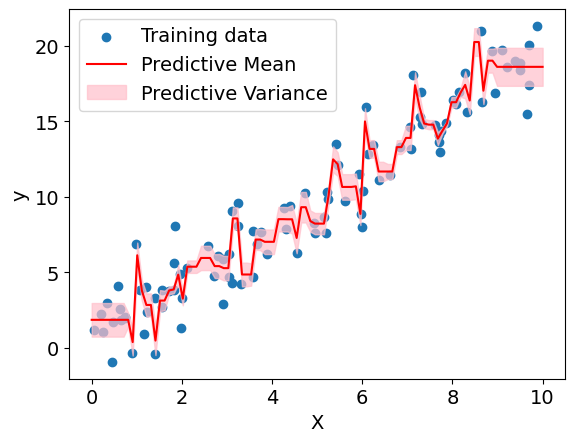

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from sklearn.ensemble import GradientBoostingRegressor

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1) * 10
y = 2 * X.squeeze() + np.random.randn(100) * 2

# Create an ngboost model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2,min_samples_leaf = 10)
ngb = NGBRegressor(Base=gbr, Dist=Normal, natural_gradient=True)

# Fit the model to the entire dataset
ngb.fit(X, y)

# Make predictions on the entire X range
X_range = np.linspace(0, 10, 100).reshape(-1, 1)
y_mean_range = ngb.predict(X_range)
y_std_range = np.sqrt(ngb.pred_dist(X_range).params['scale'])

# Plot the training dataset, predictive mean, and variance
plt.scatter(X, y, label='Training data')
plt.plot(X_range, y_mean_range, label='Predictive Mean', color='red')
plt.fill_between(X_range.squeeze(), y_mean_range - y_std_range, y_mean_range + y_std_range, color='pink', alpha=0.7, label='Predictive Variance')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


### Гауссовские процессы

Синтетические модели библиотеки ```ngboost``` позволяют получить распределение искомой величины и тем самым являются _вероятностными моделями_. Другим важным примером вероятностых моделей являются гауссовские процессы. Гауссовский процесс - это алгоритм принадлежащий к семейству ядерных методов. Это непараметрические методы машинного обучения в которых тип функции описывающей связь входного вектора и предсказаний определяется из данных.

Гауссовский процесс (ГП) - это стохастический процесс, который полностью характеризуется своим средним значением и ковариационной функцией. ГП часто используется в статистике и машинном обучении для моделирования случайных функций и данных.

Основные идеи гауссовских процессов:

1. **Нормальное распределение:** Каждый конечный набор значений из гауссовского процесса распределен нормально. Таким образом, даже если мы рассматриваем только конечное количество точек процесса, они всегда будут иметь нормальное распределение.

2. **Ковариационная функция:** Ковариационная функция определяет степень зависимости между значениями процесса в разных точках. Она указывает, насколько сильно значение в одной точке процесса коррелирует с значением в другой точке. Гауссовский процесс полностью определяется своей ковариационной функцией.

3. **Гибкость:** Гауссовские процессы обладают высокой гибкостью и могут использоваться для моделирования различных видов функций, включая гладкие кривые, периодические сигналы, шумные данные и другие.

4. **Байесовский подход:** Гауссовские процессы также широко используются в байесовском машинном обучении. При использовании ГП в качестве априорного распределения набора функций, мы можем обновлять наши представления о функции, основываясь на новых данных, с помощью теоремы Байеса.

Гауссовские процессы находят применение в различных областях, таких как регрессия, оптимизация, а также в моделировании неопределенности в различных задачах машинного обучения.

/Users/komari/lectures/From-Stats-to-ML/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


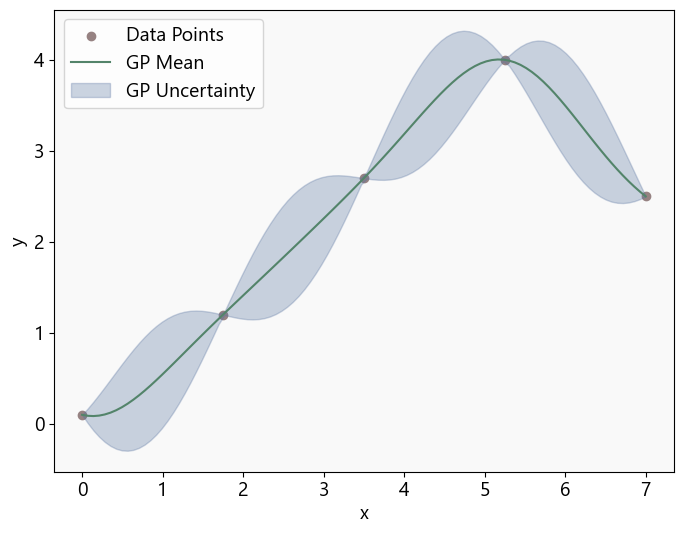

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Generate random data points
upper_l = 7
num_points = 5
x_data = np.sort(np.linspace(0, upper_l, num_points))
y_data = np.array([0.1,  1.2,  2.7,  4.0, 2.5])  # Replace with your data

# Reshape the data for GaussianProcessRegressor
x_data = x_data.reshape(-1, 1)

# Define the kernel for Gaussian Process with increased length scale
kernel =  1.0 * RBF(length_scale=0.5, length_scale_bounds=(1e-1, 1.0))

# Fit Gaussian Process to the data
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y = True)
gp.fit(x_data, y_data)

# Generate points for prediction
x_pred = np.linspace(0, upper_l, 100)
x_pred = x_pred.reshape(-1, 1)

# Predict mean and standard deviation using GP
y_pred_mean, y_pred_std = gp.predict(x_pred, return_std=True)

plt.rcParams['font.sans-serif'] = 'Segoe UI'

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, color='#968282', label='Data Points')
plt.plot(x_pred, y_pred_mean, color='#53846A', label='GP Mean')
plt.fill_between(x_pred.ravel(), y_pred_mean - y_pred_std, y_pred_mean + y_pred_std, color='#56729F', alpha=0.3, label='GP Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
# plt.title('How we believe taste depends on salt?')
plt.legend()
plt.gca().set_facecolor('#F9F9F9')
plt.grid(False)


## Конформные предсказания

Метод конформных предсказаний позволяет оценить доверительный интревал предсказаний для любой модели машинного обучения при услови взаимозаменяемости данных - то есть вероятностный закон не должен меняться из-за перемены данных (это немного более слабое требование чем тренбование независимости и одинакового распределения данных (i.i.d.)). 

Самый простой способ построения доверительных интревалов этим методом - это анализ абсолютной  ошибки (_меры конформности_ $\delta y_i$) на тренировочном (или валидационном) наборе данных:
$$\delta y_i = |y_i - \hat{y}_i|$$



/Users/komari/lectures/From-Stats-to-ML/venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


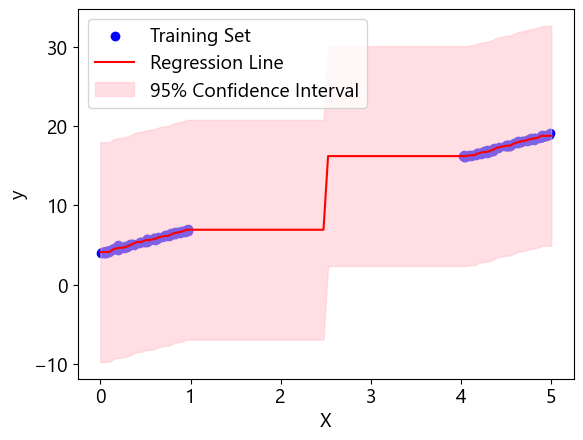

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

# Generate random data
np.random.seed(42)
X1 = np.random.rand(100, 1)
X2 = 4+np.random.rand(100, 1)
X = np.concatenate((X1,X2))
y = 4 + 3 * X + 0.1*np.random.randn(200, 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
# model = LinearRegression()
model =  GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2,min_samples_leaf = 10)
model.fit(X_train, y_train)

# Make predictions on the test set
delta_y = np.abs(y_train - model.predict(X_train))

delta_y_95p = np.quantile(delta_y, 0.95)


# Generate new data points for plotting the regression line
X_new = np.linspace(0, 5, 100).reshape(-1, 1)

# Plot the training set, regression line, and confidence interval
plt.scatter(X_train, y_train, color='blue', label='Training Set')
plt.plot(X_new, model.predict(X_new), color='red', label='Regression Line')
plt.fill_between(X_new.flatten(), (model.predict(X_new) - delta_y_95p).flatten(), (model.predict(X_new) + delta_y_95p).flatten(), color='pink', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Это вариант оценки создает доверительный интервал одинаковой ширины для любого предсказания. Кроме того, при использовании тренировочного набора данных он склонен к перетренировке, а использование валидационного набора данных требует жертвы этих самых валидационных данных для оценки ошибки.

Более продвинутые методы оценки позволяют получать распределения меры конформности из кросс-валидационных моделей. Например, Jacknife+-after-bootrstrap метод использует бутстрап для построения дополнительных моделей.

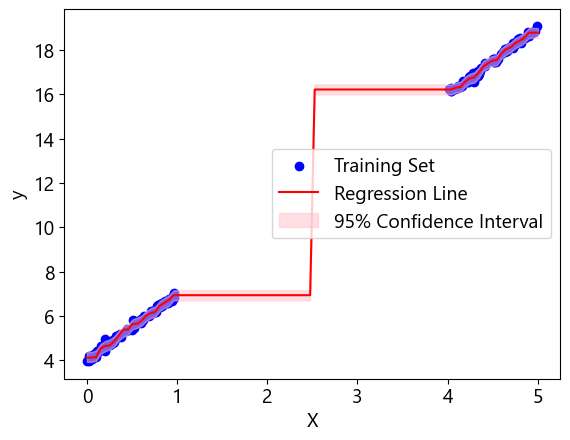

In [12]:

# Get bootrstrapped models
n_samples = 50
data = np.array(list(zip(X_train, y_train)))
data = data.reshape(len(data),2)
rng = np.random.default_rng()
bs_data = []
bs_models = []
bs_test_predictions = [[] for _ in data]
bs_train_predictions = []
for i in range(n_samples):
    # Randomly select data with replacement
    bs_indices = np.random.choice(len(data), len(data), replace=True)
    _bs_data = data[bs_indices].T

    # Find the entries that didn't make it to the random vectors
    all_indices = np.arange(len(data))
    unselected_indices = np.setdiff1d(all_indices, bs_indices)
    _data_not_in_bs = data[unselected_indices].T
    
    # Training the model
    _model =  GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2,min_samples_leaf = 10)
    _model.fit(_bs_data[0].reshape(-1,1),_bs_data[1])
    
    # Getting predictions datapoints not in the training set
    # We will use it to compute conformity scores
    bs_train_predictions += list(zip(_data_not_in_bs[0],_model.predict(_data_not_in_bs[0].reshape(-1,1))))
    
#     # Getting predictions for the training datasets
    new_predictions = _model.predict(X_new)
    for i in unselected_indices:
        bs_test_predictions[i].append(_model.predict(X_new))
    
    # Saving bootstrap results
    bs_data.append(_bs_data)
    bs_models.append(_model)
    
# Aggregating conformity scores and predictions
conformity_scores = []
mins = []
maxs = []
for i, d in enumerate(data):
    x = d[0]
    y = []
    for p in bs_train_predictions:
        if p[0] == x:
            y.append(p[1])
    conformity_score = np.abs(d[1]-np.mean(y))
    conformity_scores.append(conformity_score)
    
    predictions = np.median(np.array(bs_test_predictions[i]), axis = 0)
    
    mins.append(predictions - conformity_score)
    maxs.append(predictions + conformity_score)
    
    
mins = np.quantile(mins, 0.05, axis = 0)
maxs = np.quantile(maxs, 0.95, axis = 0)
    
# Plot the training set, regression line, and confidence interval
plt.scatter(X_train, y_train, color='blue', label='Training Set')
plt.plot(X_new, model.predict(X_new), color='red', label='Regression Line')
plt.fill_between(X_new.flatten(), mins, maxs, color='pink', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()
        

(array([ 2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0., 36., 10.,  0.,
         1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  1.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.4454181 , 0.44579813, 0.44617817, 0.4465582 , 0.44693823,
        0.44731827, 0.4476983 , 0.44807834, 0.44845837, 0.4488384 ,
        0.44921844, 0.44959847, 0.44997851, 0.45035854, 0.45073857,
        0.45111861, 0.45149864, 0.45187868, 0.45225871, 0.45263874,
        0.45301878, 0.45339881, 0.45377885, 0.45415888, 0.45453892,
        0.45491895, 0.45529898, 0.45567902, 0.45605905, 0.45643909,
        0.45681912, 0.4571

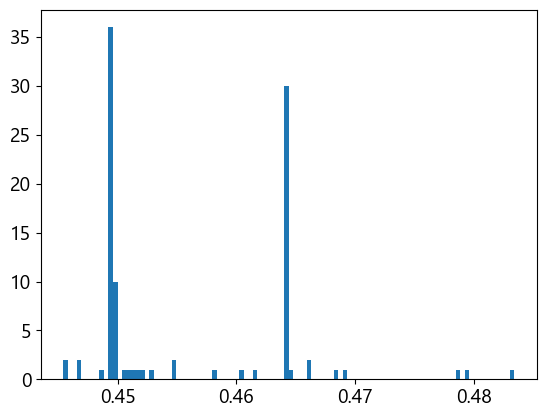

In [13]:
plt.hist(maxs-mins, bins = 100)